In [1]:
%matplotlib inline

from sklearnex import patch_sklearn 
patch_sklearn("SVC")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Import per tokenizzazione Giapponese (Python 3.8)
import re # regex 
import nagisa # Natural Language Processing for japanese
import pykakasi # library for conversion of Kanji into Hirigana, Katakana and Romaji
import heapq # library for implementing priority queues where the queue item with higher weight is given more priority in processing
from jamdict import Jamdict # library for searching the japanese vocabulary
import advertools as adv

adv.stopwords.keys()

# Tokenizzazione Inglese
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gianmariafredacivico\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gianmariafredacivico\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!


True

# Parole

### Split frasi Giapponesi in parole

In [ ]:
# Leggo dati Raw

eng_df = pd.read_csv('data/english_news.csv', delimiter='\t', low_memory=False)
jap_df = pd.read_csv('data/japanese_news.csv', delimiter='\t', low_memory=False)

jap_df = jap_df.dropna(subset='text')
eng_df = eng_df.dropna(subset='text')

In [6]:
# Print di alcune info 

for i in ['source', 'author']:
    print(i.upper())
    display(eng_df[i].describe())
    print('###########################\n')

SOURCE


count               36766
unique                  2
top       The Japan Times
freq                36692
Name: source, dtype: object

###########################

AUTHOR


count             12724
unique             1316
top       Philip Brasor
freq                318
Name: author, dtype: object

###########################



In [7]:
for i in jap_df.columns: print(f'Nan nella colonna <{i}> Giappone : {jap_df[i].isna().sum()}; percentuale: {jap_df[i].isna().sum()/len(jap_df)}')
print('\n############################################\n')
for i in jap_df.columns: print(f'Nan nella colonna <{i}> Inglese : {eng_df[i].isna().sum()}; percentuale: {eng_df[i].isna().sum()/len(eng_df)}')

Nan nella colonna <source> Giappone : 0; percentuale: 0.0
Nan nella colonna <date> Giappone : 0; percentuale: 0.0
Nan nella colonna <title> Giappone : 312916; percentuale: 0.9998785764042
Nan nella colonna <author> Giappone : 312953; percentuale: 0.9999968046422157
Nan nella colonna <text> Giappone : 0; percentuale: 0.0

############################################

Nan nella colonna <source> Inglese : 0; percentuale: 0.0
Nan nella colonna <date> Inglese : 0; percentuale: 0.0
Nan nella colonna <title> Inglese : 0; percentuale: 0.0
Nan nella colonna <author> Inglese : 24042; percentuale: 0.6539193820377522
Nan nella colonna <text> Inglese : 0; percentuale: 0.0


## Tokenizzazione parole

In [6]:
# Stop words di Inglese e Giapponese

stop_words_english = set(stopwords.words('english'))
stop_words_japanese = set(adv.stopwords['japanese'])

In [7]:
# Tokenizzazione parole

# Inglese
def clean_text_get_words(text):


    text = text.lower() 
    text = re.sub(r"\W"," ",text)
    text = re.sub(r"\d"," ",text)
    text = re.sub(r"\s+",' ',text) 
    text = re.sub(r"^\s",' ',text) 
    text = re.sub(r"\s$",' ',text) 

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum() and word.lower() not in stop_words_english]
    
    return tokens

# Giapponese
def clean_text_get_words_jap(text):


    text = text.lower() 
    text = re.sub(r"\W","",text)
    text = re.sub(r"\d","",text)
    text = re.sub(r"\s+",'',text) 
    text = re.sub(r"^\s",'',text) 
    text = re.sub(r"\s$",'',text) 
    
    tokens = nagisa.tagging(text).words
    tokens = [i for i in tokens if i not in stop_words_japanese]

    return tokens



In [10]:
# Creo colonna con le parole

import dask.dataframe as dd
from dask.multiprocessing import get
import re

import dask.dataframe as dd
from dask.multiprocessing import get

# ddata = dd.from_pandas(jap_df, npartitions=14)
# meta = pd.Series([], dtype=str)
# res = ddata.map_partitions(lambda df: df['text'].apply(clean_text_get_words_jap), meta=meta).compute(scheduler='processes')
# jap_df['words'] = res

# eng_df['words'] = eng_df['text'].apply(clean_text_get_words)

# eng_df.to_csv('eng_df.csv')
# jap_df.to_csv('jap_df.csv')

In [5]:
jap_df.head()

,source,date,title,author,text,words
0,kobe-np.co.jp,2005-07-01,NaN,NaN,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...,"['会見', '北口', '寛人', '市長', '刑事', '訴訟', '被告', '職員..."
1,kobe-np.co.jp,2005-07-01,NaN,NaN,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...,"['明石', '歩道', '橋', '事故', 'めぐる', '民事', '訴訟', '神戸..."
2,kobe-np.co.jp,2007-04-07,NaN,NaN,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...,"['会見', '後遺', '族', '代理', '人', '渡部', '吉泰', '弁護',..."
3,kobe-np.co.jp,2007-04-07,NaN,NaN,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。,"['遺族', '会', '雑踏', '警備', '本部', '長', '務め', '元', ..."
4,kobe-np.co.jp,2007-04-07,NaN,NaN,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...,"['五', '人', '遺族', '閉廷', '後', '会見', '二女', '優衣', ..."


In [6]:
eng_df.head()

,source,date,title,author,text,words
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...,"['japanese', 'government', 'trying', 'boost', ..."
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public...","['prime', 'minister', 'fumio', 'kishida', 'pub..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...,"['years', 'since', 'start', 'pacific', 'war', ..."
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was...","['world', 'changed', 'completely', 'era', 'eno..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...,"['u', 'administration', 'president', 'joe', 'b..."


In [7]:
eng_df['date'] = pd.to_datetime(eng_df.date, yearfirst=True)
jap_df['date'] = pd.to_datetime(jap_df.date, yearfirst=True)

In [23]:
for i in ['source', 'author']:
    print(i.upper())
    display(eng_df[i].describe())
    print('###########################\n')

SOURCE


count               35981
unique                  2
top       The Japan Times
freq                35907
Name: source, dtype: object

###########################

AUTHOR


count             12579
unique             1316
top       Philip Brasor
freq                318
Name: author, dtype: object

###########################



In [24]:
for i in ['source', 'author']:
    print(i.upper())
    display(jap_df[i].describe())
    print('###########################\n')

SOURCE


count          312954
unique             21
top       mainichi.jp
freq            44656
Name: source, dtype: object

###########################

AUTHOR


count       1
unique      1
top       By 
freq        1
Name: author, dtype: object

###########################



In [25]:
for i in jap_df.columns: print(f'Nan nella colonna <{i}> Giappone : {jap_df[i].isna().sum()}; percentuale: {jap_df[i].isna().sum()/len(jap_df)}')
print('\n############################################\n')
for i in jap_df.columns: print(f'Nan nella colonna <{i}> Inglese : {eng_df[i].isna().sum()}; percentuale: {eng_df[i].isna().sum()/len(eng_df)}')

Nan nella colonna <source> Giappone : 0; percentuale: 0.0
Nan nella colonna <date> Giappone : 0; percentuale: 0.0
Nan nella colonna <title> Giappone : 312916; percentuale: 0.9998785764042
Nan nella colonna <author> Giappone : 312953; percentuale: 0.9999968046422157
Nan nella colonna <text> Giappone : 0; percentuale: 0.0
Nan nella colonna <words> Giappone : 0; percentuale: 0.0

############################################

Nan nella colonna <source> Inglese : 0; percentuale: 0.0
Nan nella colonna <date> Inglese : 0; percentuale: 0.0
Nan nella colonna <title> Inglese : 0; percentuale: 0.0
Nan nella colonna <author> Inglese : 23402; percentuale: 0.6503988216002891
Nan nella colonna <text> Inglese : 0; percentuale: 0.0
Nan nella colonna <words> Inglese : 0; percentuale: 0.0


## Grafici

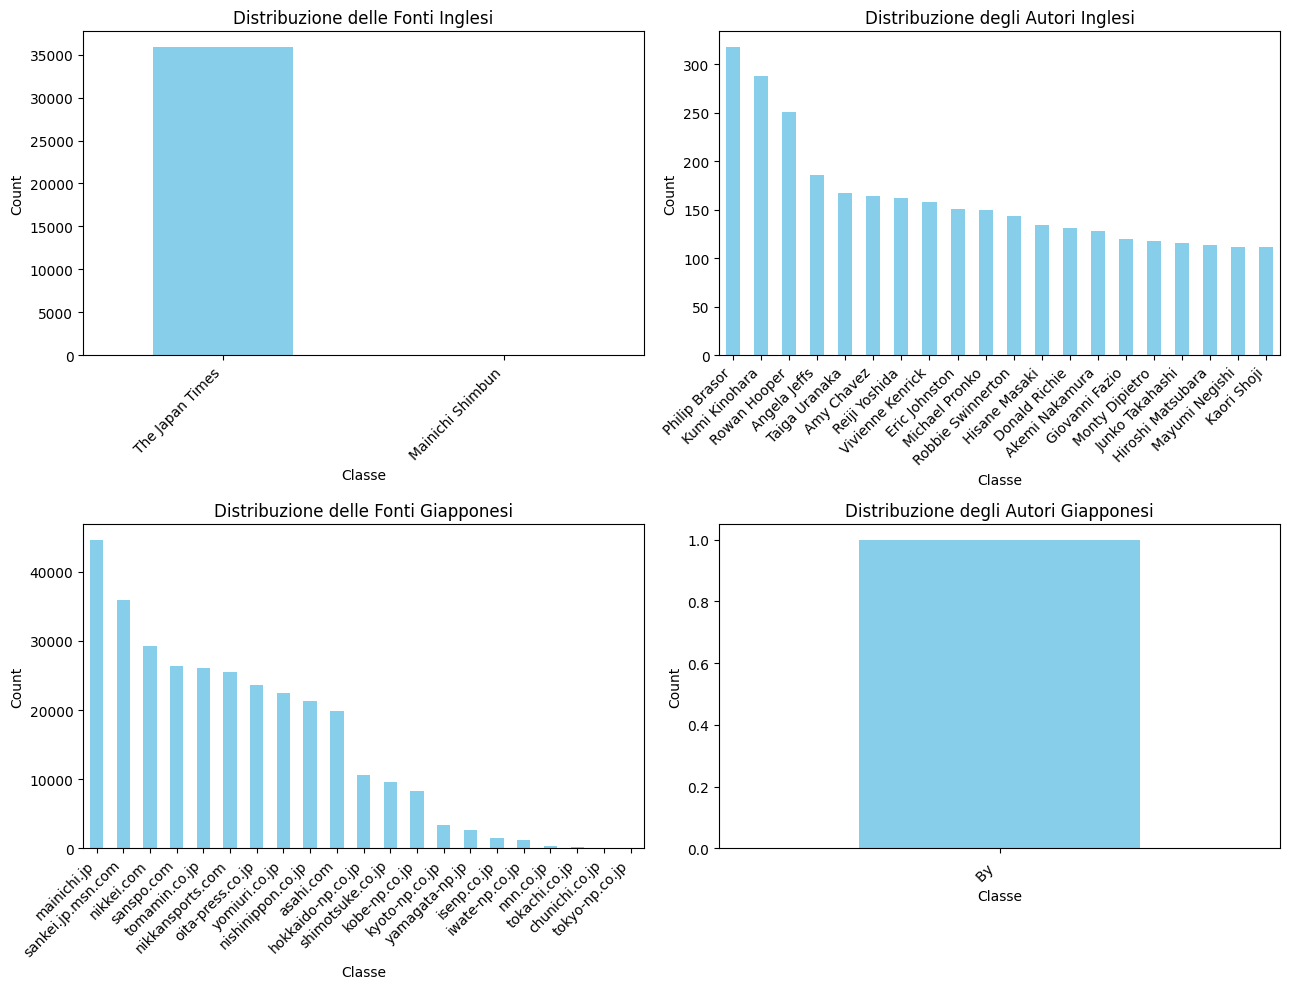

In [10]:
# Distribuzione classi

plt.figure(figsize=(13, 10))


plt.subplot(2, 2, 1)

class_counts = eng_df.source.value_counts()


class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione delle Fonti Inglesi')
plt.xlabel('Classe')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)

class_counts = eng_df.author.value_counts().head(20)

class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione degli Autori Inglesi')
plt.xlabel('Classe')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 3)

class_counts = jap_df.source.value_counts()

class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione delle Fonti Giapponesi')
plt.xlabel('Classe')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)

class_counts = jap_df.author.value_counts()

class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione degli Autori Giapponesi')
plt.xlabel('Classe')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

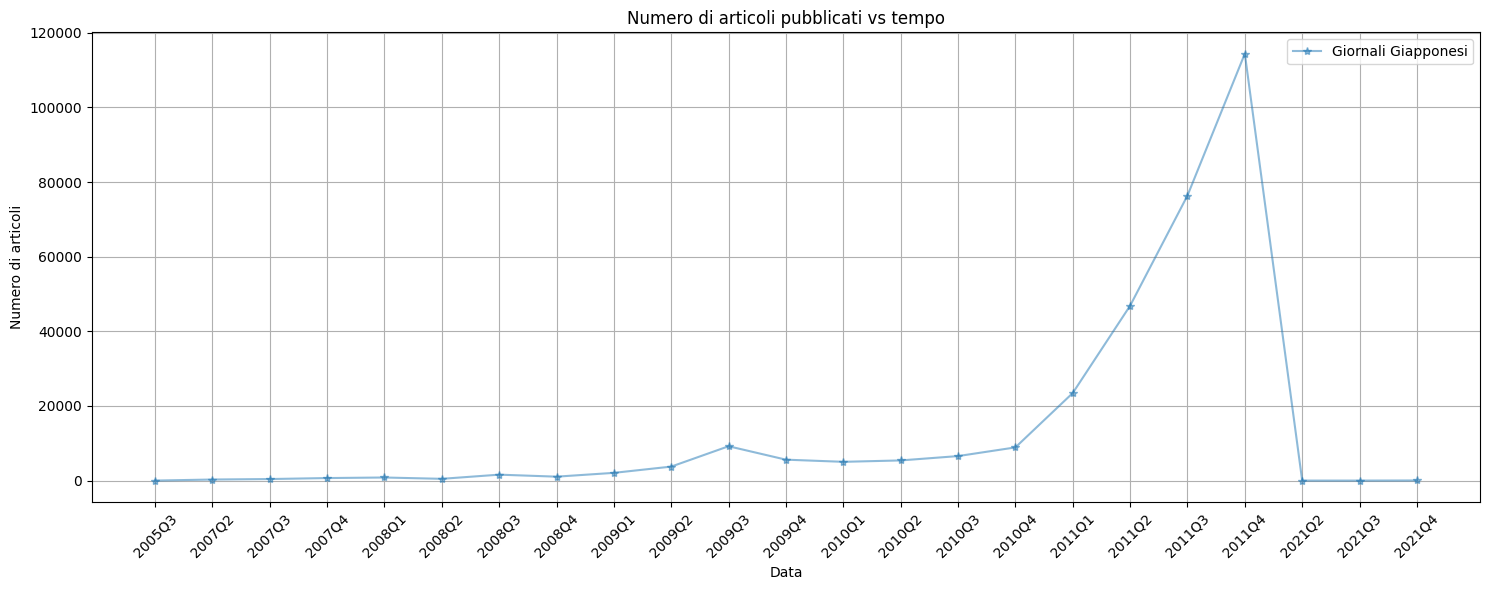

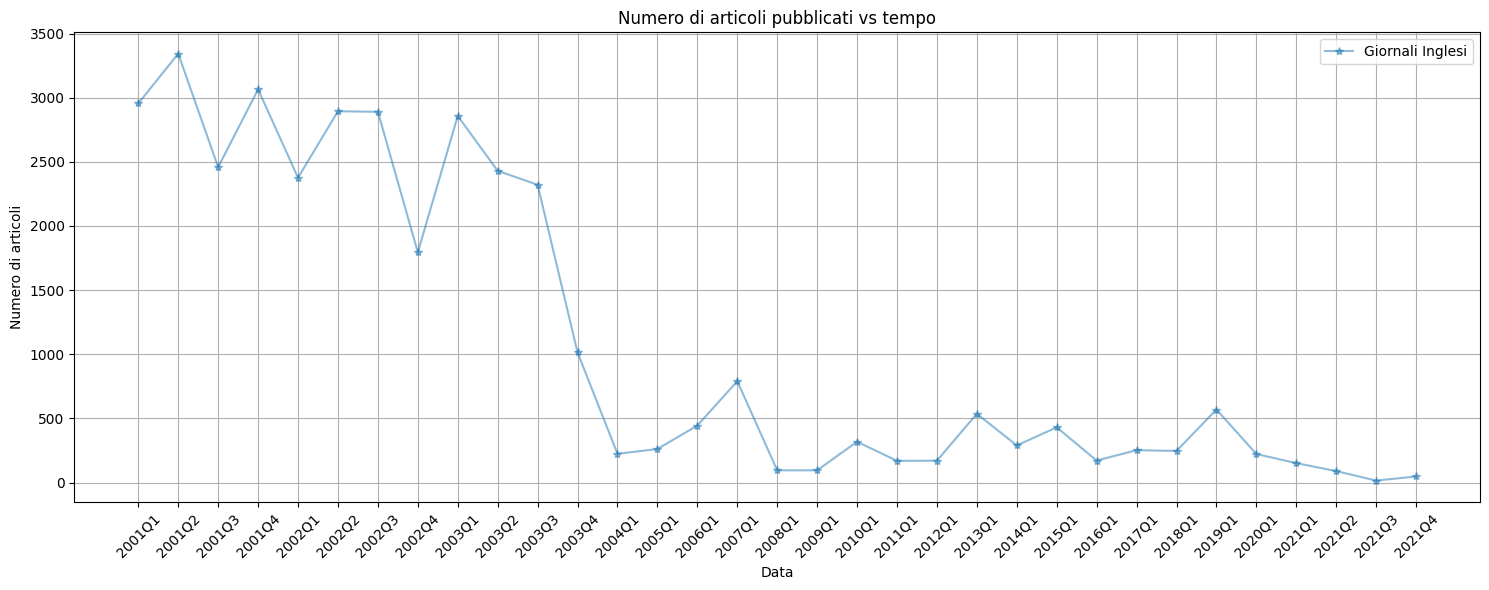

In [9]:
# Storico pubblicazioni

eng_df['year_month'] = eng_df['date'].dt.to_period('Q')
jap_df['year_month'] = jap_df['date'].dt.to_period('Q')

english_article_counts = eng_df.groupby('year_month').size()
japanese_article_counts = jap_df.groupby('year_month').size()

plt.figure(figsize=(15, 6))
# plt.plot(english_article_counts.index, english_article_counts.values, '-*', label='Giornali Inglesi', alpha=0.5)
plt.plot(japanese_article_counts.index.astype(str), japanese_article_counts.values, '-*', label='Giornali Giapponesi', alpha=0.5)
plt.title('Numero di articoli pubblicati vs tempo')
plt.xlabel('Data')
plt.ylabel('Numero di articoli')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(english_article_counts.index.astype(str), english_article_counts.values, '-*', label='Giornali Inglesi', alpha=0.5)
# plt.plot(japanese_article_counts.index, japanese_article_counts.values, '-*', label='Giornali Giapponesi', alpha=0.5)
plt.title('Numero di articoli pubblicati vs tempo')
plt.xlabel('Data')
plt.ylabel('Numero di articoli')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


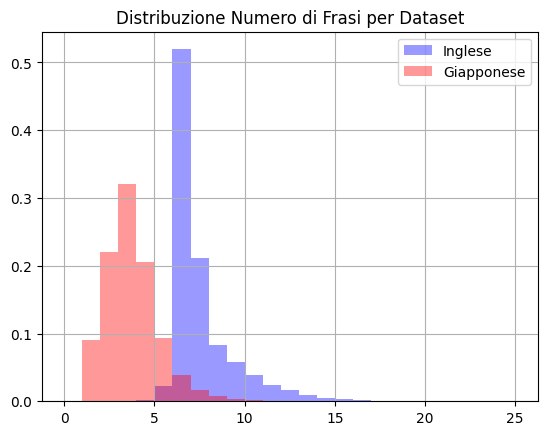

In [28]:
# Distribuzione frasi

plt.hist(eng_df.text.dropna().apply(lambda x: len(sent_tokenize(x))), bins=np.linspace(0, 25, 26), alpha=0.4, color='blue', label='Inglese', density=True)
plt.hist(jap_df.text.dropna().apply(lambda x: len(x.split('。'))), bins=np.linspace(0, 25, 26), alpha=0.4, color='red', label='Giapponese', density=True)

plt.legend()
plt.grid()
plt.title('Distribuzione Numero di Frasi per Dataset')
plt.show()

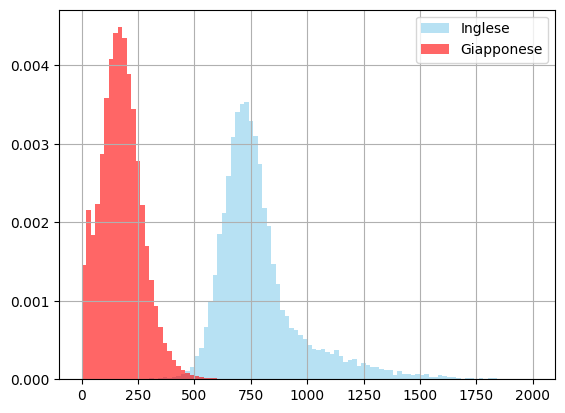

In [29]:
# Distribuzione parole

plt.hist(eng_df.words.apply(len), bins=np.linspace(0, 2000, 101), alpha=0.6, color='skyblue', density=True, label='Inglese')
plt.hist(jap_df.words.apply(len), bins=np.linspace(0, 2000, 101), alpha=0.6, color='red', density=True, label='Giapponese')

plt.legend()
plt.grid()
plt.show()

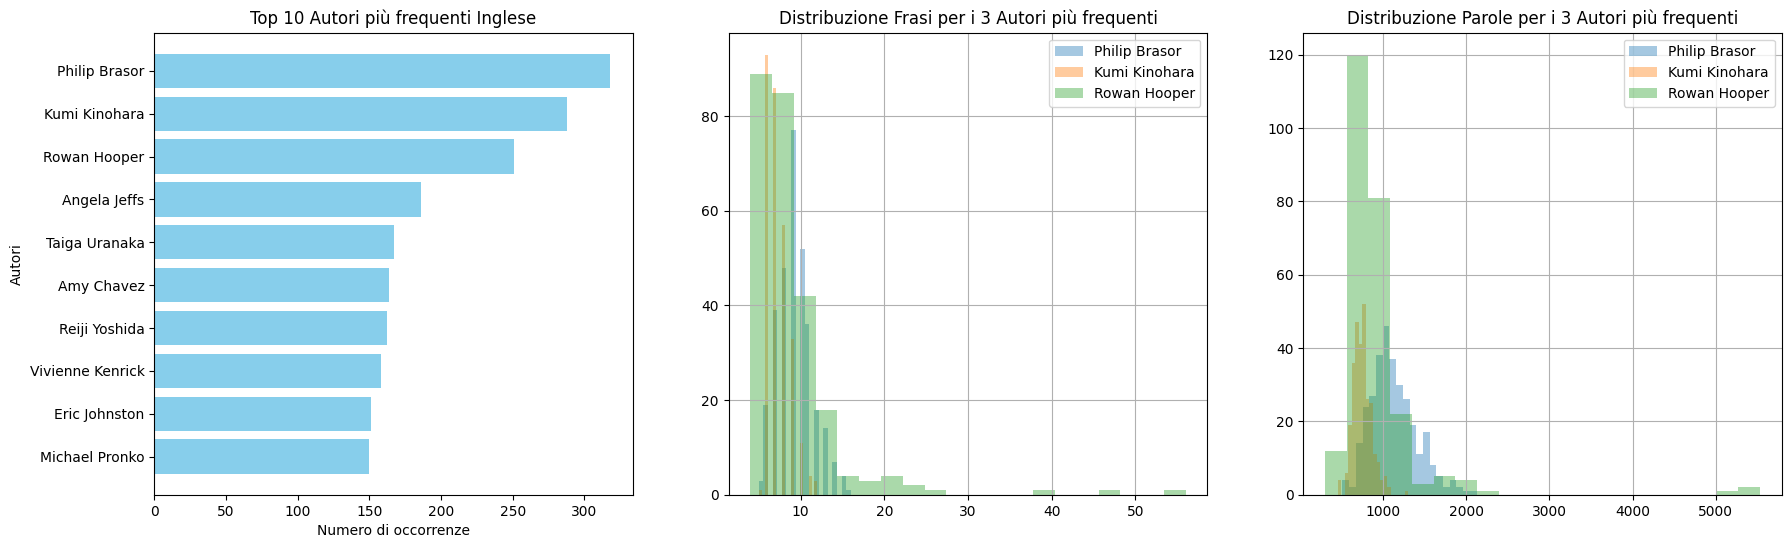

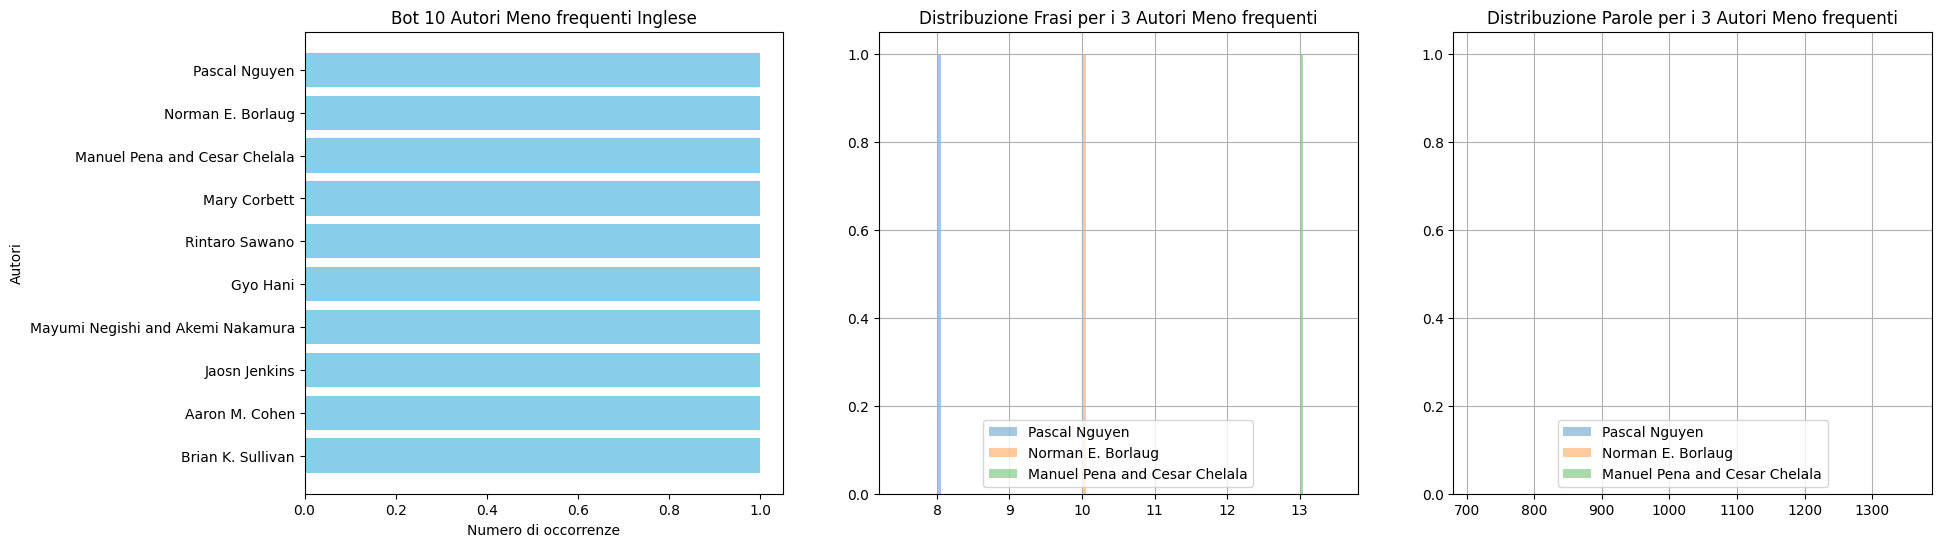

In [30]:
def plt_top_data(data, titolo, top_n=10):

    top_values = data['author'].value_counts().head(top_n)
    
    plt.figure(figsize=(21, 6))

    plt.subplot(1, 3, 1)
    plt.barh(top_values.index, top_values.values, color='skyblue')
    plt.title('Top {} {} più frequenti Inglese'.format(top_n, titolo))
    plt.xlabel('Numero di occorrenze')
    plt.ylabel(titolo)
    plt.gca().invert_yaxis()  

    plt.subplot(1, 3, 2)
    for i in top_values.index[:3]:
        temp = data[data.author == i]
        plt.hist(temp.text.apply(lambda x: len(sent_tokenize(x))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Frasi per i 3 Autori più frequenti')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    for i in top_values.index[:3]:
        temp = data[data.author == i]
        plt.hist(temp.words.apply(lambda x: len((x))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Parole per i 3 Autori più frequenti')
    plt.legend()
    plt.grid()

    bot_values = data['author'].value_counts().tail(top_n)
    
    plt.figure(figsize=(21, 6))

    plt.subplot(1, 3, 1)
    plt.barh(bot_values.index, bot_values.values, color='skyblue')
    plt.title('Bot {} {} Meno frequenti Inglese'.format(top_n, titolo))
    plt.xlabel('Numero di occorrenze')
    plt.ylabel(titolo)
    plt.gca().invert_yaxis()  

    plt.subplot(1, 3, 2)
    for i in bot_values.index[:3]:
        temp = data[data.author == i]
        plt.hist(temp.text.apply(lambda x: len(sent_tokenize(x))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Frasi per i 3 Autori Meno frequenti')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    for i in bot_values.index[:3]:
        temp = data[data.author == i]
        plt.hist(temp.words.apply(len), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Parole per i 3 Autori Meno frequenti')
    plt.legend()
    plt.grid()



    plt.show()

plt_top_data(eng_df, 'Autori')


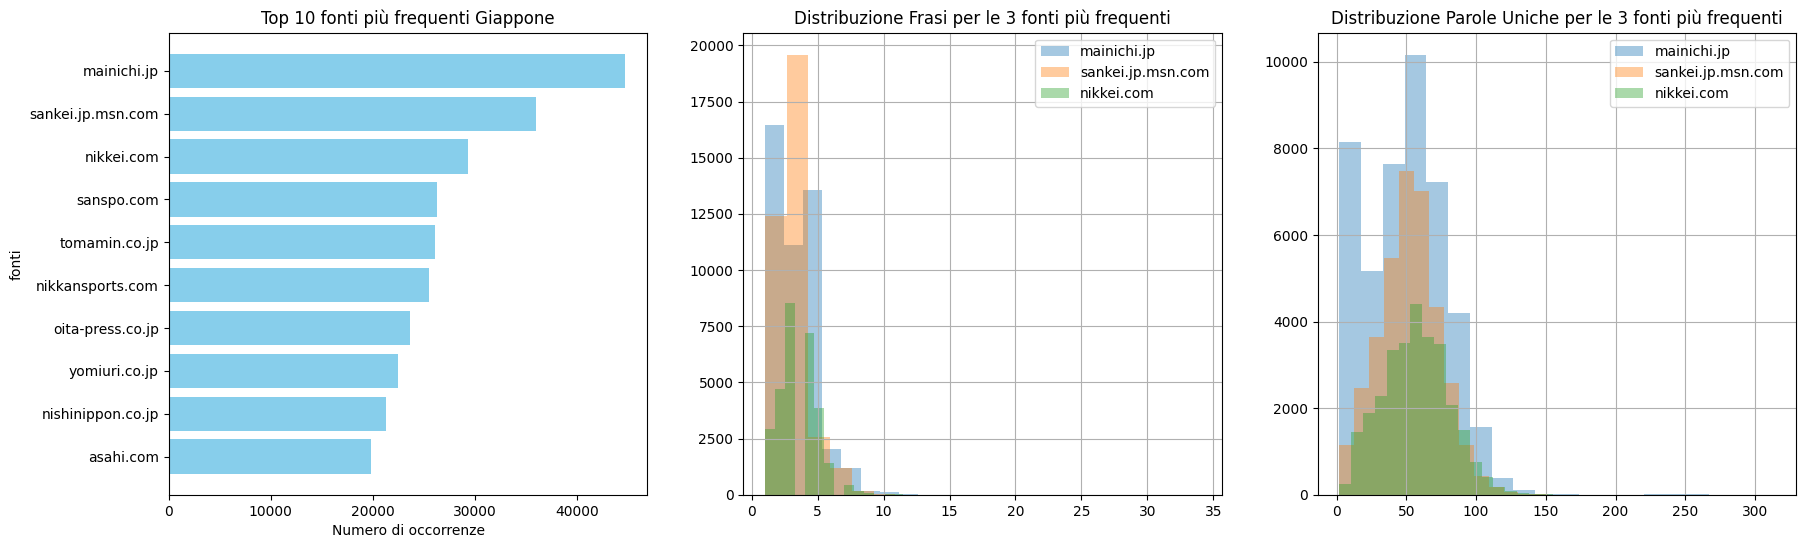

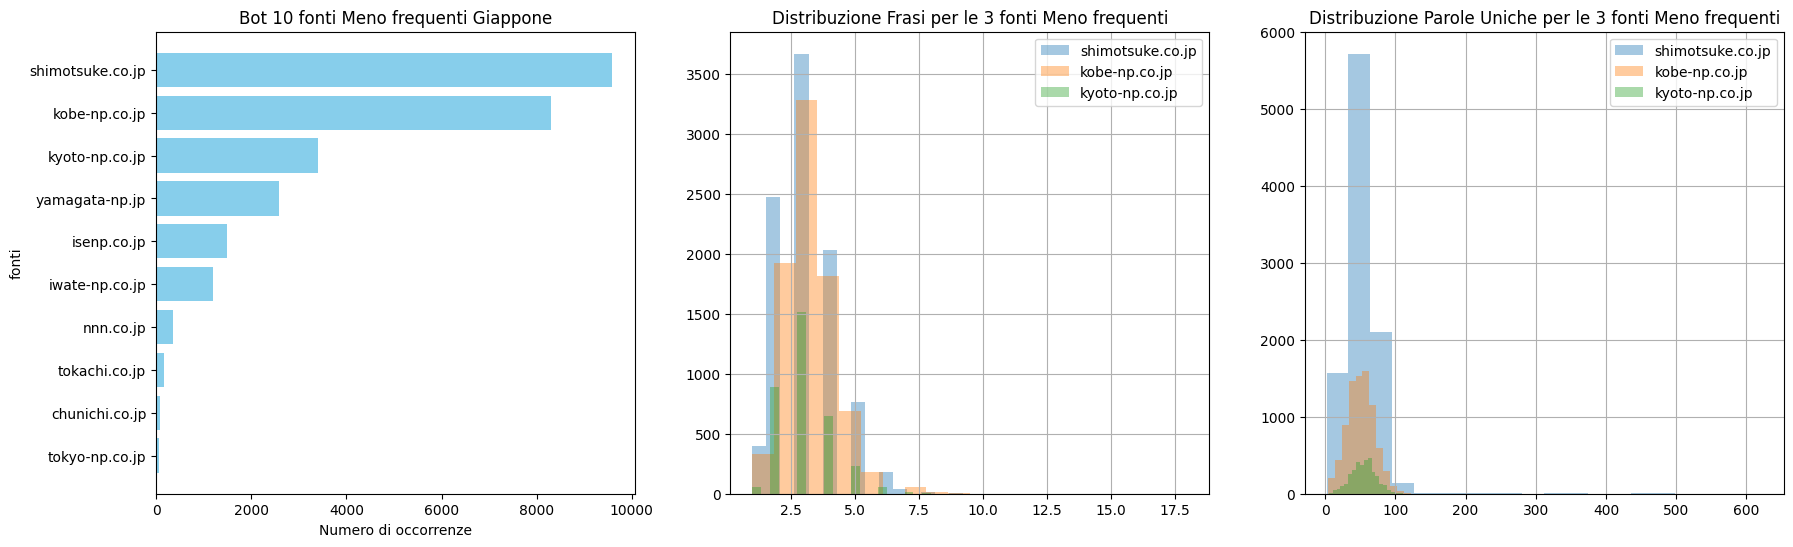

In [31]:
def plt_top_data(data, titolo, top_n=10):

    top_values = data['source'].value_counts().head(top_n)
    
    plt.figure(figsize=(21, 6))

    plt.subplot(1, 3, 1)
    plt.barh(top_values.index, top_values.values, color='skyblue')
    plt.title('Top {} {} più frequenti Giappone'.format(top_n, titolo))
    plt.xlabel('Numero di occorrenze')
    plt.ylabel(titolo)
    plt.gca().invert_yaxis()  

    plt.subplot(1, 3, 2)
    for i in top_values.index[:3]:
        temp = data[data.source == i]
        plt.hist(temp.text.apply(lambda x: len(x.split('。'))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Frasi per le 3 fonti più frequenti')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    for i in top_values.index[:3]:
        temp = data[data.source == i]
        plt.hist(temp.words.apply(lambda x: len(set(x))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Parole Uniche per le 3 fonti più frequenti')
    plt.legend()
    plt.grid()

    bot_values = data['source'].value_counts().tail(top_n)
    
    plt.figure(figsize=(21, 6))

    plt.subplot(1, 3, 1)
    plt.barh(bot_values.index, bot_values.values, color='skyblue')
    plt.title('Bot {} {} Meno frequenti Giappone'.format(top_n, titolo))
    plt.xlabel('Numero di occorrenze')
    plt.ylabel(titolo)
    plt.gca().invert_yaxis()  

    plt.subplot(1, 3, 2)
    for i in bot_values.index[:3]:
        temp = data[data.source == i]
        plt.hist(temp.text.apply(lambda x: len(x.split('。'))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Frasi per le 3 fonti Meno frequenti')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    for i in bot_values.index[:3]:
        temp = data[data.source == i]
        plt.hist(temp.words.apply(lambda x: len(set(x))), label=i, alpha=0.4, bins=20)
    plt.title('Distribuzione Parole Uniche per le 3 fonti Meno frequenti')
    plt.legend()
    plt.grid()



    plt.show()

# plt_top_data(jap_df['author'], 'autori')
plt_top_data(jap_df, 'fonti')


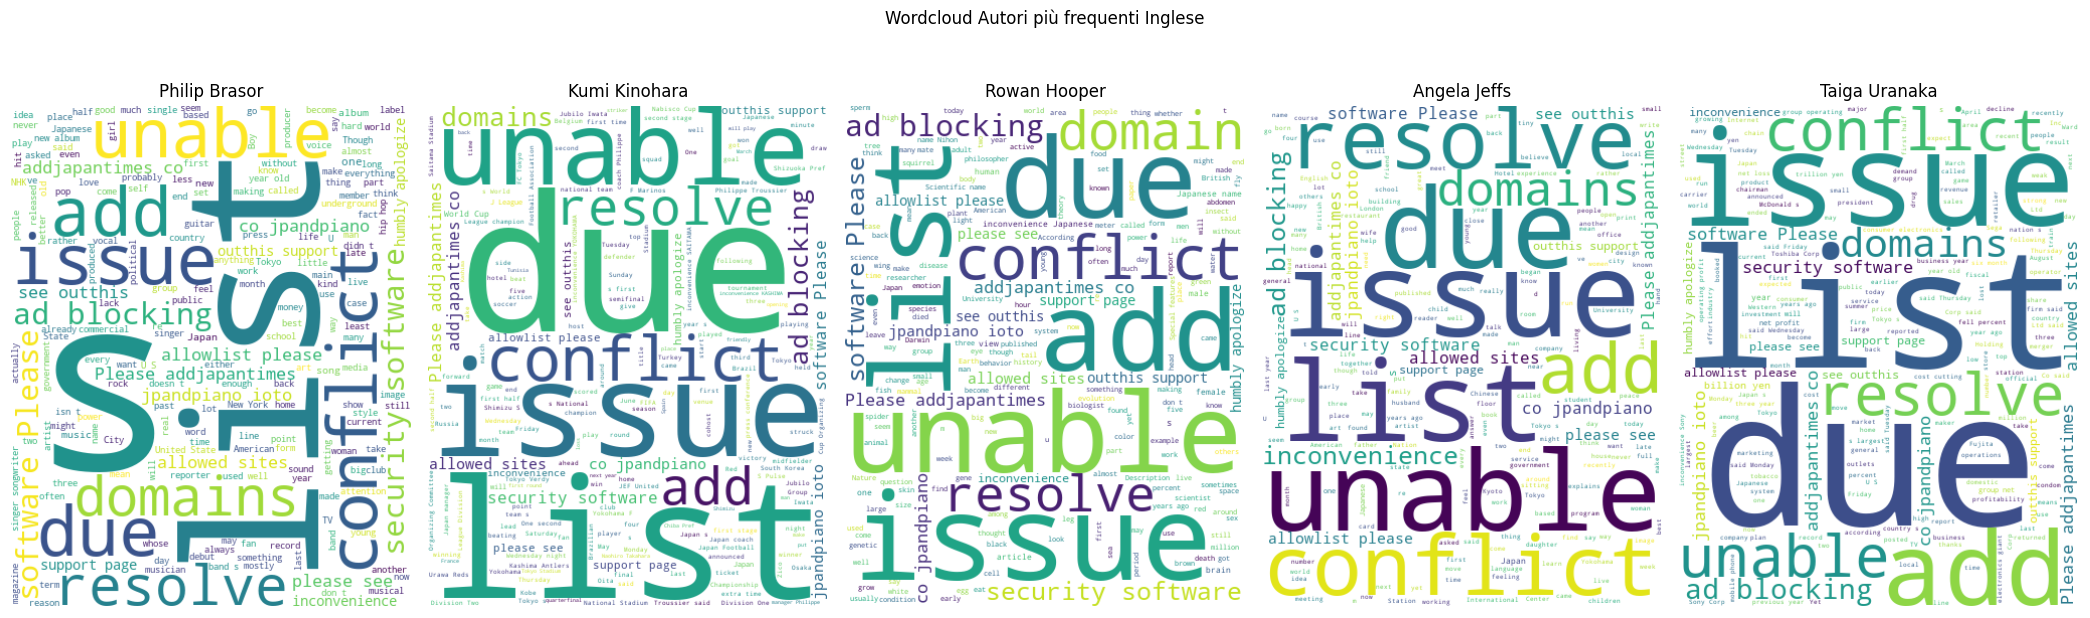

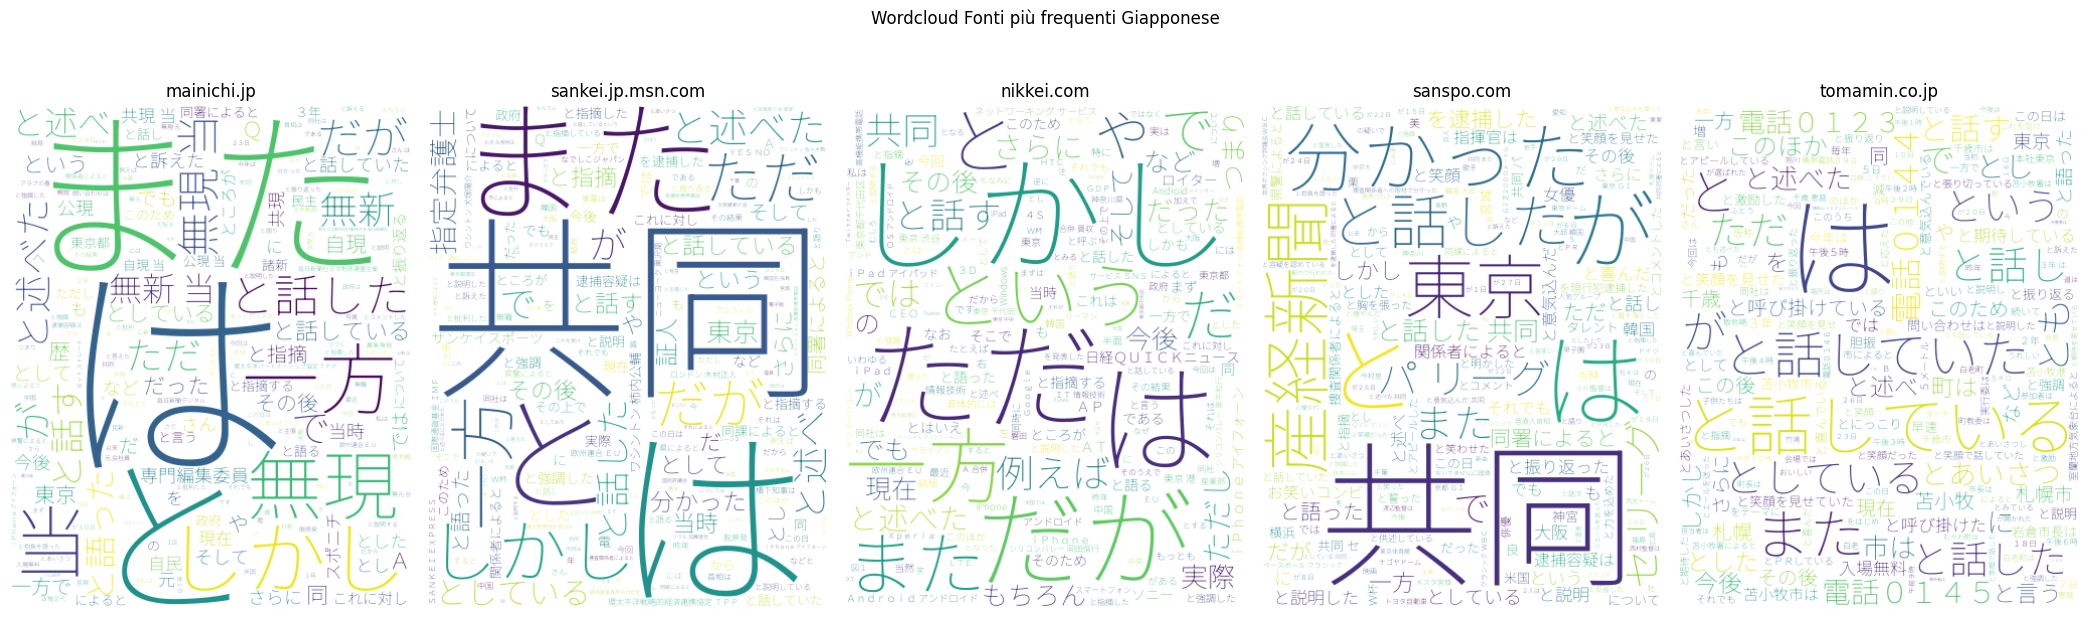

In [ ]:
from wordcloud import WordCloud

def plot_top_words(df_eng, df_jap, top_n=5):

    top_values = df_eng['author'].value_counts().head(top_n)
    
    plt.figure(figsize=(21, 6))

    for i in range(top_n):

        plt.subplot(1, top_n, i+1)
        text = df_eng[df_eng.author == top_values.index[i]].text.values
        wordcloud = WordCloud(height=500, background_color='white').generate(' '.join(text))

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(top_values.index[i])
        plt.axis('off')  
    plt.suptitle('Wordcloud Autori più frequenti Inglese', y=1.05)
    plt.tight_layout() 
    plt.show()

    top_values = df_jap['source'].value_counts().head(top_n)
    
    plt.figure(figsize=(21, 6))

    for i in range(top_n):

        plt.subplot(1, top_n, i+1)
        text = df_jap[df_jap.source == top_values.index[i]].text.values
        wordcloud = WordCloud(height=500, font_path=r'Noto_Sans_JP\NotoSansJP-VariableFont_wght.ttf', background_color='white').generate(' '.join(text))

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(top_values.index[i])
        plt.axis('off')  

    plt.suptitle('Wordcloud Fonti più frequenti Giapponese', y=1.05)
    plt.tight_layout() 
    plt.show()

plot_top_words(eng_df, jap_df)

# Preprocessing

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (classification_report, confusion_matrix,
                              precision_score, recall_score, f1_score,
                                accuracy_score, roc_auc_score, log_loss)

from gensim.models import Word2Vec

import joblib, json

from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [ ]:
# Leggo il file e droppo tutte le classi con meno di 1000 osservazioni

jap_df = pd.read_csv('data/jap_df.csv')
jap_df = jap_df.dropna(subset='text')

class_counts = jap_df['source'].value_counts()

classes_to_drop = class_counts[class_counts < 1000].index

jap_df = jap_df[~jap_df['source'].isin(classes_to_drop)]

In [33]:
import os

def mkdir(folder_path):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Cartella '{folder_path}' creata con successo.")
    else:
        print(f"La cartella '{folder_path}' esiste già.")

In [34]:
# Funzioni per creare dataset con diversi preprocessing

def tf_idf_proc(df):
    X = df.words.apply(lambda x: ' '.join(eval(x))).values
    y = df.source.values 

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

    tfidf_vectorizer = TfidfVectorizer()  
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    joblib.dump(tfidf_vectorizer, 'models/preprocessing/tfidf_vectorizer.pkl')

    return X_train_tfidf, X_test_tfidf, y_train, y_test


def w2v_proc(df):

    X = df.words.apply(lambda x: ' '.join(eval(x))).values

    w2v = Word2Vec(sentences=X, vector_size=100, window=5, min_count=1, workers=4)
    df['embedding_mean'] = df.words.apply(lambda x: np.mean([w2v.wv[i] for i in eval(x) if i in w2v.wv], axis=0).tolist())
    df = df.dropna(subset='embedding_mean')

    X = np.vstack(df['embedding_mean'].values)

    y = df.source.values 

    label_encoder = LabelEncoder()

    y_encoded = label_encoder.fit_transform(y)

    print(X.shape, y_encoded.shape)
    joblib.dump(w2v, 'models/preprocessing/w2v.pkl')
    return train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

def d2v_proc(df):

    tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(df['words'].apply(eval).values)]

    d2v = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
    d2v.build_vocab(tagged_data)
    d2v.train(tagged_data, total_examples=d2v.corpus_count, epochs=d2v.epochs)


    X = np.array([d2v.infer_vector(words) for words in df['words'].apply(eval).values])
    y = df.source.values 

    label_encoder = LabelEncoder()

    y_encoded = label_encoder.fit_transform(y)

    print(X.shape, y_encoded.shape)

    joblib.dump(d2v, 'models/preprocessing/d2v.pkl')

    return train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [35]:
# Creo i dataset e li salvo per non doverli rifare

X_train_idf, X_test_idf, y_train_idf, y_test_idf = tf_idf_proc(jap_df)
# X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = w2v_proc(jap_df)
# X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = d2v_proc(jap_df)

df_train_w2v = pd.read_csv('data/processed/train_w2v.csv')
X_train_w2v = df_train_w2v.drop(columns=['label']).values
y_train_w2v = df_train_w2v['label']

df_test_w2v = pd.read_csv('data/processed/test_w2v.csv')
X_test_w2v = df_test_w2v.drop(columns=['label']).values
y_test_w2v = df_test_w2v['label']

df_train_d2v = pd.read_csv('data/processed/train_d2v.csv')
X_train_d2v = df_train_d2v.drop(columns=['label']).values
y_train_d2v = df_train_d2v['label']

df_test_d2v = pd.read_csv('data/processed/test_d2v.csv')
X_test_d2v = df_test_d2v.drop(columns=['label']).values
y_test_d2v = df_test_d2v['label']

In [10]:
# mkdir('data/processed')

# df_train_w2v = pd.DataFrame(X_train_w2v)
# df_train_w2v['label'] = y_train_w2v
# df_train_w2v.to_csv('data/processed/train_w2v.csv', index=False)

# df_test_w2v = pd.DataFrame(X_test_w2v)
# df_test_w2v['label'] = y_test_w2v
# df_test_w2v.to_csv('data/processed/test_w2v.csv', index=False)

# df_train_d2v = pd.DataFrame(X_train_d2v)
# df_train_d2v['label'] = y_train_d2v
# df_train_d2v.to_csv('data/processed/train_d2v.csv', index=False)

# df_test_d2v = pd.DataFrame(X_test_d2v)
# df_test_d2v['label'] = y_test_d2v
# df_test_d2v.to_csv('data/processed/test_d2v.csv', index=False)


In [11]:
# print(np.unique(y_train_d2v).shape)
# print(np.unique(y_test_d2v).shape)
# print(np.unique(y_train_w2v).shape)
# print(np.unique(y_test_w2v).shape)

In [10]:
print(len(y_train_d2v.unique()))
print(len(y_test_d2v.unique()))
print(len(y_train_w2v.unique()))
print(len(y_test_w2v.unique()))

17
17
17
17


In [41]:
# funzioni per Train modello e plot risultati

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score

def plot_cm(y_test, y_pred, path):
    cm = confusion_matrix(y_test, y_pred)

    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap="Blues")
    plt.savefig(path)
    plt.close()

def train_model_and_plot_cm(model, dataset, path):


    if dataset == 'tf-idf':
        X_train, X_test, y_train, y_test = X_train_idf, X_test_idf, y_train_idf, y_test_idf
    elif dataset == 'word2vec':
        X_train, X_test, y_train, y_test = X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v
    elif dataset == 'doc2vec':
        X_train, X_test, y_train, y_test = X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v
    else:
        raise ValueError("Dataset non valido. Utilizzare 'tf-idf', 'word2vec' o 'doc2vec'.")

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    try:
        y_pred_proba = model.predict_proba(X_test)
        loss = log_loss(y_test, y_pred_proba)

    except:
        y_pred_proba = 0
        loss = 'NA'
        
    plot_cm(y_test, y_pred, path  + '/jap/confusion_matrix_' + dataset + '.png')

    joblib.dump(model, path + '/jap/' + str(model).split('(')[0] + '_' + dataset + '.pkl')
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)

    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame.from_dict(report).T.to_csv(path + '/jap/_classification_report_' + dataset + '.csv')

    performance_metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': acc,
        'log_loss': loss
    }

    with open(path + '/jap/_metrics_' + dataset + '.json', 'w') as f:
        json.dump(performance_metrics, f)

    return model, performance_metrics


### Provo prima solo con i testi Giapponesi

In [38]:
xgboost_folder = 'models/xgboost'
svc_folder = 'models/svc'
random_forest_folder = 'models/random_forest'
NBayes_folder = 'models/NBayes'
LR_folder = 'models/LR'

In [16]:
# mkdir(xgboost_folder)
# mkdir(svc_folder)
# mkdir(random_forest_folder)
# mkdir(NBayes_folder)
# mkdir(LR_folder)

Cartella 'models/NBayes' creata con successo.


In [39]:
xgboost_model = XGBClassifier(objective='multi:softmax', num_class=17, eval_metric='merror', n_estimators=100)
svc_model =  SVC(kernel='linear', verbose=1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=1000)

In [17]:
# xgb_trained_tfidf, xgb_performances_tfidf = train_model_and_plot_cm(xgboost_model, 'tf-idf', xgboost_folder)
# xgb_trained_w2v, xgb_performances_w2v = train_model_and_plot_cm(xgboost_model, 'word2vec', xgboost_folder)
# xgb_trained_d2v, xgb_performances_d2v = train_model_and_plot_cm(xgboost_model, 'doc2vec', xgboost_folder)

# RF_trained_w2v, RF_performances_w2v = train_model_and_plot_cm(rf_model, 'word2vec', random_forest_folder)
# RF_trained_d2v, RF_performances_d2v = train_model_and_plot_cm(rf_model, 'doc2vec', random_forest_folder)

# LR_trained_w2v, LR_performances_w2v = train_model_and_plot_cm(lr_model, 'word2vec', LR_folder)
# LR_trained_d2v, LR_performances_d2v = train_model_and_plot_cm(lr_model, 'doc2vec', LR_folder)
# print('Done')

In [17]:
NB_trained_w2v, NB_performances_w2v = train_model_and_plot_cm(nb_model, 'tf-idf', NBayes_folder)

c:\Users\gianmariafredacivico\OneDrive - FairConnect SA\Desktop\Digitiamo\archive\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gianmariafredacivico\OneDrive - FairConnect SA\Desktop\Digitiamo\archive\.venv\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\gianmariafredacivico\OneDrive - FairConnect SA\Desktop\Digitiamo\archive\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

In [42]:
svc_trained_w2v, svc_performances_w2v = train_model_and_plot_cm(svc_model, 'word2vec', svc_folder)
print(2)

svc_trained_d2v, svc_performances_d2v = train_model_and_plot_cm(svc_model, 'doc2vec', svc_folder)
print(3)

INFO:sklearnex: sklearn.svm.SVC.fit: running accelerated version on CPU
sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
c:\Users\gianmariafredacivico\OneDrive - FairConnect SA\Desktop\Digitiamo\archive\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set 

2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.svm.SVC.predict: running accelerated version on CPU
sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
c:\Users\gianmariafredacivico\OneDrive - FairConnect SA\Desktop\Digitiamo\archive\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

3


In [11]:
import os
import json

models_preprocessing = {
    "xgboost": ["doc2vec", "word2vec"],
    "svc": ["doc2vec", "word2vec"],
    "random_forest": ["doc2vec", "word2vec"],
    "LR": ["doc2vec", "word2vec"],
    "NBayes": ["tf-idf"]
}

models_folder = "models"

def read_metrics_from_json(json_file):
    with open(json_file, 'r') as f:
        metrics = json.load(f)
    return metrics

def write_metrics_to_file(model_name, metrics_dict, output_file):
    with open(output_file, 'a') as f:
        f.write(f"Modello: {model_name}\n")
        for preprocessing_type, metrics in metrics_dict.items():
            f.write(f"Preprocessing: {preprocessing_type}\n")
            for metric, value in metrics.items():
                f.write(f"{metric}={value}, ")
            f.write("\n")
        f.write("\n")


def analyze_models(models_preprocessing):

    output_folder = "metrics_summary"
    os.makedirs(output_folder, exist_ok=True)
    output_file = os.path.join(output_folder, "metrics_summary.txt")
    

    for model, preprocessing_types in models_preprocessing.items():

        model_folder_path = os.path.join(models_folder, model)
        

        if os.path.isdir(model_folder_path):

            model_metrics = {}
            

            for preprocessing_type in preprocessing_types:

                metrics_json_file = os.path.join(model_folder_path, f"_metrics_{preprocessing_type}.json")
                

                if os.path.exists(metrics_json_file):

                    metrics_dict = read_metrics_from_json(metrics_json_file)
                    

                    model_metrics[preprocessing_type] = metrics_dict
            

            write_metrics_to_file(model, model_metrics, output_file)


analyze_models(models_preprocessing)



Riassunto delle metriche completato.
